In [102]:
# Import necessary packages.
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from matplotlib.image import imread
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
import cv2
from IPython.display import clear_output
import time

In [103]:
from TelopsToolbox.hcc.readIRCam import read_ircam
from TelopsToolbox.hcc.writeIRCam import write_ircam
import TelopsToolbox.utils.image_processing as ip

import matplotlib.patches as patches
from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from IPython.display import clear_output

import matplotlib.ticker as mticker
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [104]:
fs = 24

# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs) 

## Background image

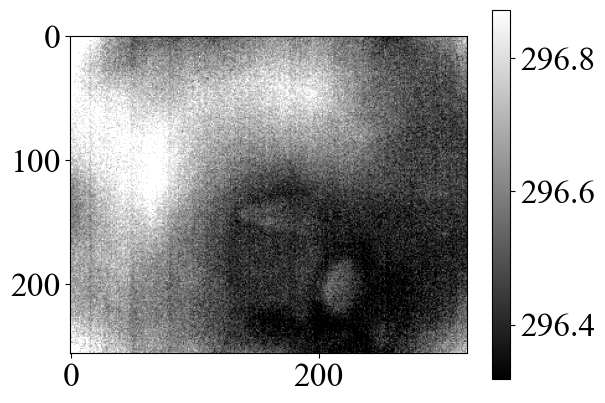

In [105]:
bg_data, header, specialPixel, nonSpecialPixel = read_ircam(r'E:\IC3X_IR\FST 806\BG\_20240821T185449679_20240821T185547262.hcc', frames=list(
    range(0, 50)))

header_df = pd.DataFrame(header)
frame = bg_data[0]

""" print a frame """
image_2D = ip.form_image(header, frame)
c_lim = ip.image_scaling_limits(frame)
vmin, vmax = c_lim.squeeze()
plt.figure(1)
plt.imshow(image_2D.squeeze(), vmin=vmin, vmax=vmax, cmap='gray')
plt.colorbar()


In [108]:
bg_data, header, specialPixel, nonSpecialPixel = read_ircam(r'E:\IC3X_IR\FST 806\BG\_20240821T185449679_20240821T185547262.hcc')
bg_2D = ip.form_image(header, bg_data)

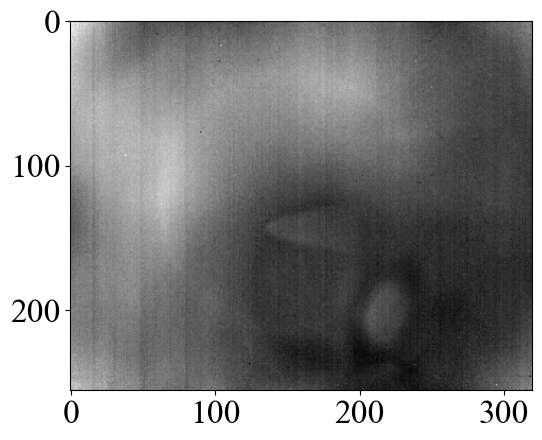

In [109]:
# Calculating mean image
bg_mean = np.mean(bg_2D, axis = 0)

# plotting image
#%matplotlib notebook
plt.figure()
plt.imshow(bg_mean, cmap = 'gray')

## Run image

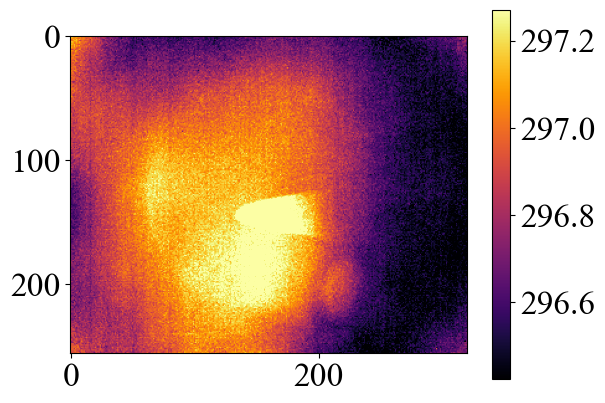

In [106]:
run_data, header, specialPixel, nonSpecialPixel = read_ircam(r'E:\IC3X_IR\FST 806\run\_20240821T185551720_20240821T190452224.hcc')
header_df = pd.DataFrame(header)
frame = run_data[0]

""" print a frame """
run_2D = ip.form_image(header, run_data)
c_lim = ip.image_scaling_limits(frame)
vmin, vmax = c_lim.squeeze()
plt.figure(1)
plt.imshow(run_2D[0].squeeze(), vmin=vmin, vmax=vmax, cmap='inferno')
plt.colorbar()

In [107]:
run_2D.shape

(618, 256, 320)

In [33]:
run_2D.shape[0]

618

### Background subtraction and Realignment

In [110]:
#Image Registration 

# Calculating instantaneous images python
begin_time = time.time() 

# # creating matrix to house images for averaging
shift_m = np.zeros((run_2D.shape[0],2))

i_ratio     = np.zeros((run_2D.shape[0],run_2D.shape[1],run_2D.shape[2]))
Temperature = np.zeros((run_2D.shape[0],run_2D.shape[1],run_2D.shape[2]))

for i in range((run_2D.shape[0])):
    im_run = run_2D[i,:,:]
    
    # Setting counter
    clear_output(wait = True) 
    a = i + 1                                    # Counter for cycle for, increases 1 on each loop
    print('Image #: ' + str(a), end='\r')        # Printing string 
    
    image = run_2D[1,:,:]# using first image from target run images as true location                                         
    offset_image = im_run   
    shift, error, diffphase = phase_cross_correlation(image, offset_image, upsample_factor= 100) # Read article
    
    ##----- Realigning image based on shift
    height, width = image.shape[:2] # gettingimage size
    tx, ty = shift[1] , shift[0] # getting shift values
    shift_m[i,0] = tx
    shift_m[i,1] = ty

    # Create the translation matrix using tx and ty, it is a NumPy array 
    translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)

    # apply the translation to the image
    im_trans = cv2.warpAffine(src=im_run, M=translation_matrix, dsize=(width, height))    
    
    ##----- Performing background subtraction
    a1 = (im_trans - bg_mean)
    
    Temperature[i,:,:]=a1
    
print('Execution time :'+ str(round(time.time() - begin_time,2))+'s')

Image #: 618
Execution time :7.03s


In [111]:
Temperature.shape

(618, 256, 320)

### Mean Temperature

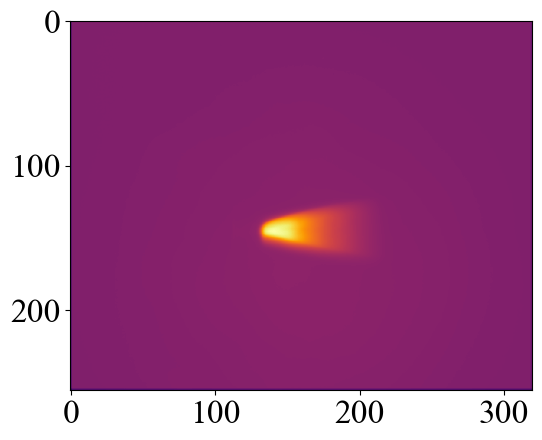

In [113]:
# Calculating mean image
T_mean = np.mean(Temperature, axis = 0)

# plotting image
#%matplotlib notebook
plt.figure()
plt.imshow(T_mean, cmap = 'inferno')

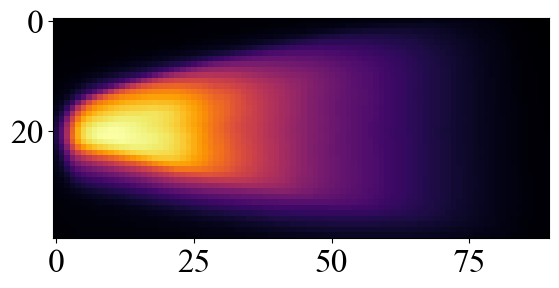

In [114]:
plt.figure()
plt.imshow(T_mean[125:165,130:220], cmap = 'inferno')

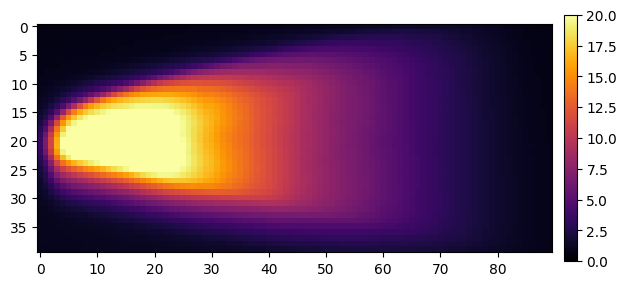

In [56]:
plt.figure(figsize=[8,8])
plt.imshow(T_mean[125:165,130:220], cmap = 'inferno', vmin = 0 , vmax = 20)#cmap = 'turbo', vmin = 0.2 , vmax = 1.1
plt.colorbar(shrink=0.4, pad = 0.02)

In [98]:
Y,X = Temperature[0,125:165,130:220].shape #Temperature[:,:,0].shape
#y_1 = 128-2

#origin_x, origin_y = 840,y_1+9
origin_x, origin_y = 90,20
#origin_x, origin_y = 978,105

#scale = 10*25.4/838 # mm/pixel
#scale= 9.96*25.4/973.96
scale= 1.38*25.4/165

x_coords = scale*(origin_x - np.arange(0,X,1))
y_coords = scale*(origin_y - np.arange(0,Y,1))
dia = 25.4 # mm

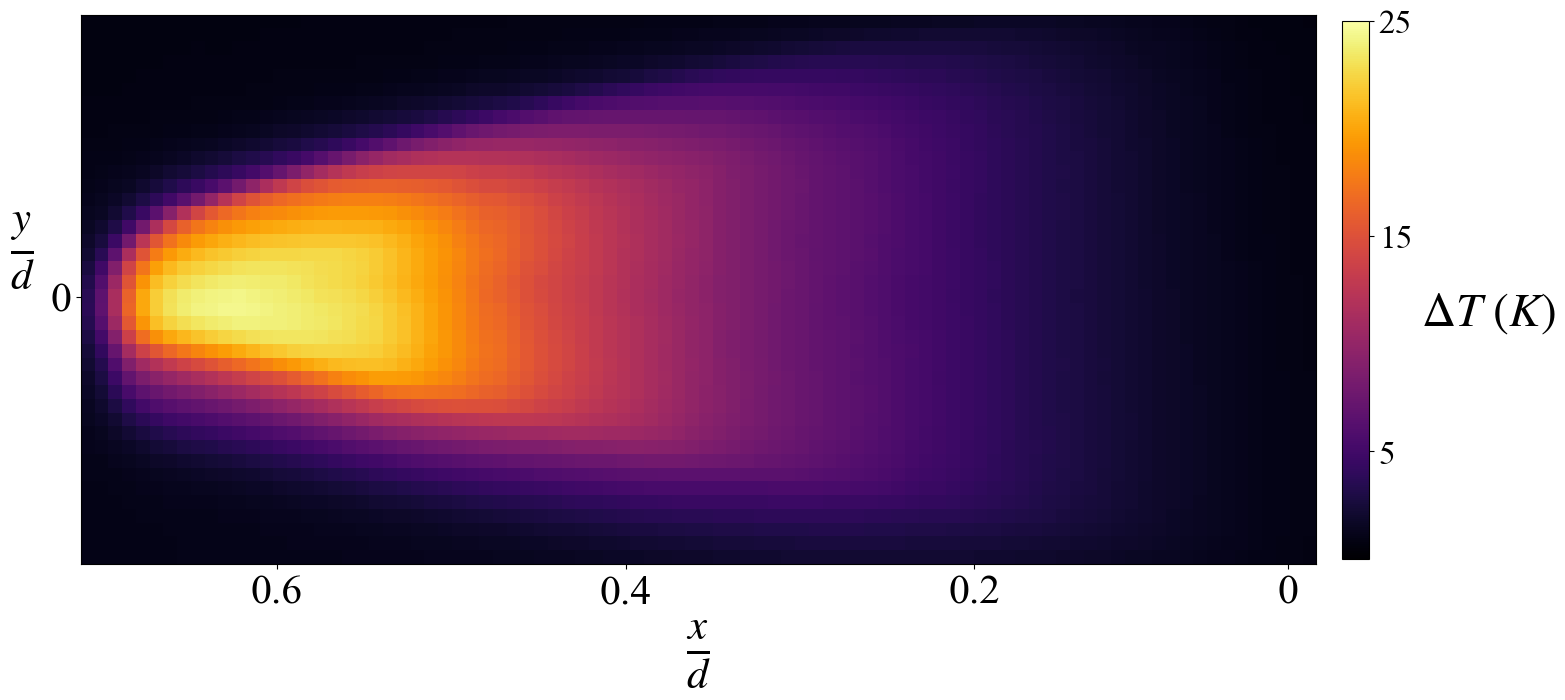

In [99]:
fig, ax = plt.subplots()
fig.set_size_inches(15,12)
fig.tight_layout(pad=5.0)


# T_m=delT_mean #np.fliplr(T_mean/426) 
ic3x = T_mean[125:165,130:220] #ma.masked_where(I_ref<=thresh,T_m)

#plt.imshow(ic3x, cmap = 'turbo', vmin = -0.015,vmax = 0.0)#5AoA
plt.imshow(ic3x, cmap = 'inferno', vmin = 0, vmax = 25)
cba = plt.colorbar(shrink=0.6, pad = 0.02, fraction = 0.047*(Y/X))
cba.set_label(r'${\Delta T}\ (K)$', rotation=0, fontsize = fs+10, labelpad = 55)
cba.set_ticks([5,15,25])
xt = -np.array([0.1,1,2,3])*dia +origin_x
yt = -np.array([0])*dia + origin_y
plt.xticks(xt, fontsize=fs+6)
plt.yticks(yt, fontsize=fs+6)


ticks_y = mticker.FuncFormatter(lambda y, pos: '{0:g}'.format(np.round(scale*(origin_y-y)/dia),1))
ax.yaxis.set_major_formatter(ticks_y)

ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(scale*(origin_x-x)/dia,1),1))
ax.xaxis.set_major_formatter(ticks_x)

plt.xlabel(r'$\frac{x}{d}$', fontsize = fs+20)
plt.ylabel(r'$\frac{y}{d}$',rotation = 0, fontsize = fs+20, labelpad = 20)
plt.show()

### Save data as npz array

In [100]:
np.savez_compressed(r'E:\IC3X_IR\TSP_IC3X_IR.npz', 
                    bg_mean = bg_mean, 
                    Temperature = Temperature, 
                    T_cropped = Temperature[:,125:165,130:220])

In [101]:
save_dir = r"E:\IC3X_IR\FST 806\delT"
for i in range(Temperature.shape[0]):
    img = Temperature[i,125:165,130:220]
    mpimg.imsave(save_dir +r"\R" + rf'{i:06}' + r".tiff", img , cmap = 'inferno', vmin = 0 , vmax = 25, dpi = 350)#